In [24]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim


from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler

In [25]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((128,128)),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
dataset = datasets.ImageFolder('../dataset', transform=transform)

    

In [26]:
valid_size_and_test = 0.4 # then I will keep 0.1 for testing 

## split the dataset into train and rest data
targets = dataset.targets

train_idx, rest_idx = train_test_split(np.arange(len(targets)), test_size= 
                    valid_size_and_test, random_state=42, shuffle=True, stratify=targets)
                    
test_size = int(len(rest_idx) * valid_size_and_test)
valid_idx, test_idx = rest_idx[:test_size], rest_idx[test_size:]

dataloaders = {'trainLoader' : torch.utils.data.DataLoader(dataset,batch_size=32,sampler=SubsetRandomSampler(train_idx)),
               'validLoader' : torch.utils.data.DataLoader(dataset,batch_size=32,sampler=SubsetRandomSampler(valid_idx)),
               'testLoader' :  torch.utils.data.DataLoader(dataset,batch_size=32,sampler=SubsetRandomSampler(test_idx)),
              }

In [27]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)  

In [28]:
# Create CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        # Convolution 3
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0)
        self.relu3 = nn.ReLU()
        
        # Max pool 2
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1
        self.fc1 = nn.Linear(64 * 12 * 12, 64) 
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(64, 2)
    
    def forward(self, x):
        # Set 1
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        
        # Set 2
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)

        # Set 3
        out = self.cnn3(out)
        out = self.relu3(out)
        out = self.maxpool3(out)
        
        #Flatten
        out = out.view(out.size(0), -1)

        #Dense
        out = self.fc1(out)
        out = self.relu4(out)
        out = self.fc2(out)
        
        return out

model = CNNModel()
model = model.to(device)

#Definition of hyperparameters
batch_size = 32
num_epochs = 100

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [22]:
# CNN model training

count = 0
loss_list = []
iteration_list = []
accuracy_list = []
train_loader = dataloaders["trainLoader"]
test_loader = dataloaders["testLoader"]
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # train = Variable(images.view(100,1,28,28))
        # labels = Variable(labels)
        images = images.to(device)
        labels = labels.to(device)
        # Clear gradients
        optimizer.zero_grad()
        # Forward propagation
        outputs = model(images)
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        # Calculating gradients
        loss.backward()
        # Update parameters
        optimizer.step()
        
        count += 1
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                
                # test = Variable(images.view(100,1,28,28))
                images = images.to(device)
                labels = labels.to(device)
                # Forward propagation
                outputs = model(images)
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

torch.save(model, "../model/model.pt")

/mnt/mount-3.7T/masud/Project/EducationProject/Face_Mask_Detection/venv/lib/python3.6/site-packages/PIL/Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
Iteration: 500  Loss: 0.6810335516929626  Accuracy: 77.2727279663086 %


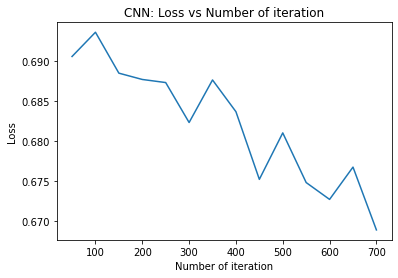

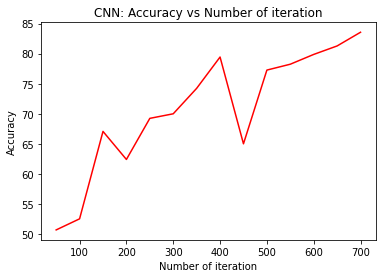

In [23]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()